# RF모델링, 훈련데이터로 훈련 고.

In [71]:
import numpy as np
import os
import sys
import glob
import pickle
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import pickle


In [75]:
len(X_test)

3288

In [74]:
len(Y_test)

3288

In [76]:
# 1. task정하고, 해당 task의 데이터&라벨 가져오기
grid_search = True

for task in range(1, 15):
    fname  = f"/media/hoseung/nv4t/backup/Work/BBS_data/skeleton/task{task:02}_"
    data = np.load(fname+"data.npy")
    label = np.load(fname+"label.npy")

    # 2. 데이터 정규화 (0~1), 훈련/테스트셋 나누기, 데이터셋저장하기 

    sc = preprocessing.MinMaxScaler(feature_range=(0,1))
    data = sc.fit_transform(data)
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
        data,label,test_size=0.2,stratify=label)

    pickle.dump({
    'train_x':X_train,
    'train_y':Y_train,
    'test_x':X_test,
    'test_y':Y_test,
    'label' : label},open(fname+"dataset.pickle",'wb'))

    # 3. 모델링    
    if grid_search:
        total_nodes_constraint = 8192
        possible_n_estimators = [16, 20, 32, 40]
        combinations = [(n_est, total_nodes_constraint // n_est) for n_est in possible_n_estimators if total_nodes_constraint // n_est > 1]
        param_grid = {
            'n_estimators': [combo[0] for combo in combinations],
            'max_leaf_nodes': [combo[1] for combo in combinations],
            'max_features': [None, 'sqrt', 'log2'],
            'bootstrap': [True, False]
        }

        rf = RandomForestClassifier()
        grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, Y_train)

        model = grid_search.best_estimator_
    else:
        ntree = 20
        max_depth = 8
        model = RandomForestClassifier(n_estimators=ntree, max_depth=max_depth)
        model.fit(X_train,Y_train)
    
    Y_predicted = model.predict(X_test)
    print(f"Task {task},  Accuracy : {accuracy_score(Y_test,Y_predicted):.3f}")
     
    # Feature importance
    importances = model.feature_importances_
    threshold = 0.001  # This value can be tuned based on your understanding of the domain and data.
    unused_features = [ind for ind, importance in enumerate(importances) if importance < threshold]
    print("UNUSED FEATURE", unused_features)

    pickle.dump(model, open(fname+'trained_model.pickle','wb'))

Task 1,  Accuracy : 0.884
UNUSED FEATURE []
Task 2,  Accuracy : 0.867
UNUSED FEATURE []
Task 3,  Accuracy : 0.847
UNUSED FEATURE []
Task 4,  Accuracy : 0.869
UNUSED FEATURE []
Task 5,  Accuracy : 0.879
UNUSED FEATURE [171, 183]
Task 6,  Accuracy : 0.864
UNUSED FEATURE []
Task 7,  Accuracy : 0.859
UNUSED FEATURE []
Task 8,  Accuracy : 0.996
UNUSED FEATURE []
Task 9,  Accuracy : 0.927
UNUSED FEATURE []
Task 10,  Accuracy : 0.981
UNUSED FEATURE []
Task 11,  Accuracy : 0.966
UNUSED FEATURE []
Task 12,  Accuracy : 0.850
UNUSED FEATURE []
Task 13,  Accuracy : 0.862
UNUSED FEATURE []
Task 14,  Accuracy : 0.947
UNUSED FEATURE []


In [77]:
accs = np.array([0.884, 0.867, 0.847, 0.869, 0.879, 0.864, 0.859, 0.996, 0.927, 0.981, 0.966, 0.850, 0.862, 0.947])

In [78]:
np.mean(accs)

0.8998571428571427

## best combination given the number of trees * depth limitation

In [55]:
from sklearn.model_selection import GridSearchCV

total_nodes_constraint = 8192

possible_n_estimators = [16, 20, 32, 40]

combinations = [(n_est, total_nodes_constraint // n_est) for n_est in possible_n_estimators if total_nodes_constraint // n_est > 1]

param_grid = {
    'n_estimators': [combo[0] for combo in combinations],
    'max_leaf_nodes': [combo[1] for combo in combinations],
    'max_features': [None, 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, Y_train)

best_rf = grid_search.best_estimator_

evaluate_tree(best_rf, X_test, Y_test)

## Check for unused features

In [68]:
import matplotlib.pyplot as plt 

(array([10., 58., 87., 52., 31., 10.,  4.,  4.,  1.,  3.]),
 array([0.00157945, 0.00233959, 0.00309973, 0.00385986, 0.00462   ,
        0.00538014, 0.00614028, 0.00690041, 0.00766055, 0.00842069,
        0.00918083]),
 <BarContainer object of 10 artists>)

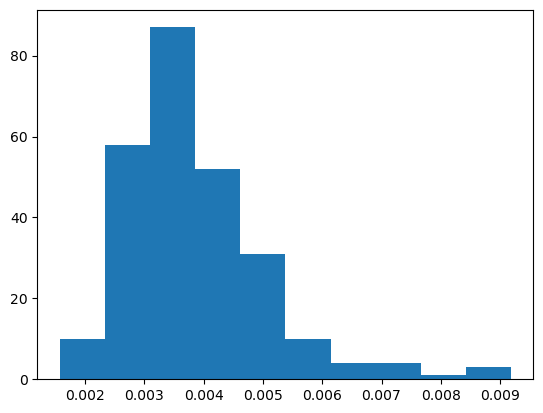

In [69]:
plt.hist(importances)

In [61]:
best_rf.n_estimators

40

In [ ]:
best_rf.n_estimators.

# Post pruning 

In [41]:
def evaluate_tree(tree, X, y):
    y_pred = tree.predict(X)
    return accuracy_score(y, y_pred)

def evaluate_trees(forest, X, y):
    tree_scores = [evaluate_tree(tree, X, y) for tree in forest.estimators_]
    return tree_scores

In [46]:
tree_scores = evaluate_tree(model, X_test, Y_test)

In [47]:
tree_scores

0.9122592479364109

In [51]:
for tree in model.estimators_:
    y_pred = tree.predict(X_test)
    print(accuracy_score(Y_test, y_pred))

0.5955365331702843
0.6227453378171813
0.6062366248853561
0.6105166615713848
0.5787221033323143
0.6193824518495873
0.6242739223479058
0.6016508712931825
0.6597370834607154
0.620605319474167
0.6239682054417609
0.6215224701926017
0.6358911647814124
0.6151024151635586
0.6416997859981657
0.6282482421277896
0.616936716600428
0.623662488535616
0.6193824518495873
0.6028737389177622
0.6472026903087741
0.5710791806786916
0.6004280036686028
0.6416997859981657
0.6264139406909202
0.6095995108529502
0.6157138489758484
0.6190767349434424
0.6123509630082543
0.6184653011311525
0.6383369000305716
0.6196881687557322
